## Simulation of Holistic path project in Federated Learninig Settings using flower
### Authors: Yazan Ghafir - Alex Bellander
### Supervisors: Mina Alebeigi - Johan Östman

### Imports

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os
import flwr as fl
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from enum import Enum
from tqdm import tqdm
import gc
from numba import cuda 
import networkx as nx
import random
import time
import enum
import threading


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

# import the ZOD DevKit
from zod import ZodFrames
from zod import ZodSequences

# import default constants
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject

''' type of ML task. The loss function will be chosen accordingly'''
class TASK(Enum): CLASSIFICATION = 1; REGRESSION = 2;
    
available_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{available_device} is available in this machine using PyTorch {torch.__version__} and Flower {fl.__version__}")
print(f"Pytorch version: {torchvision.__version__}")

cuda is available in this machine using PyTorch 1.12.1+cu102 and Flower 1.3.0
Pytorch version: 0.13.1+cu102


### Hyper parameters

In [2]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 2
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.003
USE_GPU=False
NUM_GLOBAL_ROUNDS = 3
NUM_LOCAL_EPOCHS = 10
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

### Data loading

In [16]:
dataset_root = "/home/s0001721/mnt/ZOD-AI-SWEDEN"
version = "full"  # "mini" or "full"
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)

training_frames_all = zod_frames.get_split(constants.TRAIN)
validation_frames_all = zod_frames.get_split(constants.VAL)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [17]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 269
validation_frames length: 30


In [9]:
class ZodDataset(Dataset):
    def __init__(self, zod_frames, frames_id_set, transform=None, target_transform=None):
        self.zod_frames = zod_frames
        self.frames_id_set = frames_id_set
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frames_id_set)

    def __getitem__(self, idx):
        frame_idx = self.frames_id_set[idx]
        frame = self.zod_frames[frame_idx]
        
        image = frame.get_image(Anonymization.DNAT)
        poses = frame.ego_motion.poses
        x = poses[:,0:1,3]
        y = poses[:,1:2,3]
        z = poses[:,2:3,3]
        coordinates = np.append(x,y)
        coordinates = np.append(coordinates,z)
        
        label = coordinates.astype('float32')
        image = image.astype('float32')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [10]:
def load_datasets(num_clients: int):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE))])

    trainset = ZodDataset(zod_frames=zod_frames, frames_id_set=training_frames, transform=transform)
    testset = ZodDataset(zod_frames=zod_frames, frames_id_set=validation_frames, transform=transform)
    
    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * (num_clients -1)
    lengths.append(len(trainset) - sum(lengths))
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // VAL_PART  
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

### Models

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.is_pretrained=False
        stride = 1
        nr_cv = 2
        # get the dimentions correct
        size_before_fc = IMG_SIZE
        for i in range(0,nr_cv): size_before_fc = (size_before_fc - 2*stride) // 2

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=stride, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=stride, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            nn.Linear(size_before_fc*size_before_fc*64, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, NUM_OUTPUT),
        )

    def forward(self, x):
        return np.squeeze(self.conv(x))

    def model_parameters(self):
        return self.parameters()

class PTNet(nn.Module):
    def __init__(self) -> None:
        super(PTNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.is_pretrained=True

        """freeze parameters and replace head"""
        for param in self.model.parameters():
            param.requires_grad = False
        self.change_head_net()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return np.squeeze(self.model(x))

    def model_parameters(self):
        return self.get_head().parameters()

    def change_head_fc(self):
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, NUM_OUTPUT)

    def change_head_net(self):
        num_ftrs = self.model.fc.in_features
        head_net = nn.Sequential(
            nn.Linear(num_ftrs, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, NUM_OUTPUT, bias=True),
        )
        self.model.fc = head_net

    def get_head(self):
        return self.model.fc

### Training, evaluation and utilities

In [12]:
def train(net,trainloader, valloader, 
          epochs: int, contin_val=True, plot = True,
          client_cid=None, verbose=0, model_name=""):
    
    """Train the network on the training set."""
    print(f'⇉ Started transfer learning of model {model_name}' if net.is_pretrained else f'Started normal learning of model {model_name}')
    num_batches = len(trainloader)
    print_every = (num_batches // 3) if (num_batches // 3) != 0 else 1
    
    criterion = torch.nn.CrossEntropyLoss() if ML_TASK == TASK.CLASSIFICATION else torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.model_parameters())
    net.train()
    
    losses = []; accs = []; val_losses = []; val_accs = [];
    for epoch in range(epochs):
        correct, total, epoch_acc, epoch_val_accuracy = 0, 0, 0.0, 0.0;
        epoch_loss = []
        for batch_index, (images, labels) in enumerate(trainloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics
            epoch_loss.append(loss.item())
            total += labels.size(0)
            
            if(ML_TASK == TASK.CLASSIFICATION):
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
                
            if batch_index % print_every == 0 and verbose>0:
                print(f"\tBatch {batch_index}/{num_batches}: Train loss: {sum(epoch_loss[-print_every:])/print_every:.3f}, ")
        
        epoch_loss = np.mean(epoch_loss)
        epoch_val_loss, epoch_val_accuracy = test(net, valloader)
        losses.append(epoch_loss); 
        val_losses.append(epoch_val_loss);
        
        if(ML_TASK == TASK.CLASSIFICATION):
            epoch_acc = correct / total
            accs.append(epoch_acc);
            val_accs.append(epoch_val_accuracy);
            
            print(f" ↪ Client{client_cid} Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}, val loss {epoch_val_loss}, accuracy {epoch_val_accuracy}")
        else: 
            print(f" ↪ Client{client_cid} Epoch {epoch+1}: train loss {epoch_loss},\t val loss {epoch_val_loss}")

    if(plot):
      if(ML_TASK == TASK.CLASSIFICATION):
          fig, ax = plt.subplots(ncols=2, figsize=(8,4))
          plot_metrics(ax, [[losses,val_losses],[accs,val_accs]], [f'Corss Entropy Loss - model {model_name}',f'Accuracy - model {model_name}'], ['Number of epochs','Number of epochs'], [['Train', 'Val'],['Train', 'Val']])
      else: 
          fig, ax = plt.subplots(ncols=1, figsize=(8,4))
          plot_metrics([ax], [[losses,val_losses]], [f'RMSE Loss - model {model_name}'], [f'Number of epochs - model {model_name}'], [['Train', 'Val']])
        
    if(client_cid):
        save_model(net, client_cid)
    
    print("For manual plotting:")
    print(f"Client{client_cid} Train losses = {losses}")
    print(f"Client{client_cid} Val_losses = {val_losses}")
    return losses, accs, val_losses, val_accs


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss() if ML_TASK == TASK.CLASSIFICATION else torch.nn.MSELoss()
    correct, total = 0, 0
    net.eval()
    loss = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            outputs = outputs.unsqueeze(0) if outputs.shape[0] != 1 else outputs
            labels = labels.unsqueeze(0) if labels.shape[0] != 1 else labels
            loss.append(criterion(outputs, labels).item())

            if(ML_TASK == TASK.CLASSIFICATION):
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    loss = np.mean(loss)
    accuracy = correct / total if ML_TASK == TASK.CLASSIFICATION else None
    return loss, accuracy


def get_parameters(net) -> List[np.ndarray]:
    if(PRINT_DEBUG_DATA): print("⤺ Get model parameters")
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    if(PRINT_DEBUG_DATA): print("⤻ Set model parameters")
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) if v.shape != torch.Size([]) else torch.Tensor([0]) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model(net, name):
    print(f"🔒 Saved the model of client {name} to the disk. 🔒")
    torch.save(net.state_dict(), f'{name}.pth')

def load_model(name):
    print(f"🛅 Loaded the model of client {name} from the disk. 🛅")
    net = net_instance(f"{name}")
    net = net.load_state_dict(torch.load(f'{name}.pth'))
    add_active_model(net)
    return net

def print_gpu_processes(extra_info=None):
    try:
        if(extra_info):
            print(extra_info, torch.cuda.list_gpu_processes())
        else:
            print(torch.cuda.list_gpu_processes())
    except: pass
    
def clear_gpu():
    print_gpu_processes()
    print("started clearing the GPU RAM.")
    try:
        gc.collect()
        torch.cuda.empty_cache()
    except:
        print("Could not clear the GPU RAM.")
    print_gpu_processes()
    print("Done clearing the GPU RAM.")

def add_active_model(m):
    active_models.append(m)
    
def plot_metrics(axs, metrics, titles, xlabels, legends, ylim=None):
    for i, ax in enumerate(axs):
        for m in metrics[i]:
          ax.plot(m)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.legend(legends[i])
        if ylim:
            ax.set_ylim(ylim)
    
def net_instance(name):
    net = PTNet().to(DEVICE) if RUN_PRETRAINED else Net().to(DEVICE)
    print(f"🌻 Created new model - {name} 🌻")
    return net

def destroy_model(model, name):
    print_gpu_processes(f"⍤ [show gpu process usage before destroying model {name}] ⍤")
    model=model.cpu()
    #odel.destroy()
    del model
    print(f"꧁ destroyed model - {name} ꧂")
    print_gpu_processes(f"⍤ [show gpu process usage after destroying model {name}] ⍤")

def use_cpu(model=None):
    print("swiched to cpu")
    DEVICE = torch.device('cpu')
    if(model):
        model=model.cpu()

def use_gpu():
    print("swiched to gpu")
    DEVICE = torch.device('cuda')

def plot_client_losses(clients_data):
    for client in clients_data:
        fig, ax = plt.subplots(ncols=1, figsize=(8,4))
        plot_metrics([ax], [[client.losses,client.val_losses]], ['RMSE Loss'], ['Number of epochs'], [['Train', 'Val']])

# Centralized Settings

### Hyper parameters

In [9]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 5
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.003
USE_GPU=False
NUM_GLOBAL_ROUNDS = 2
NUM_LOCAL_EPOCHS = 6
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

In [10]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 269
validation_frames length: 30


In [11]:
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [ ]:
def run_centralized(print_summery=False):
    # clear gpu
    clear_gpu()
    
    # create the net
    net = net_instance("Centralized")
    
    # data
    trainloader = trainloaders[0]
    valloader = valloaders[0]
    
    # summery
    print('nr of training imgs:', len(trainloader.dataset))
    print('nr of validation imgs:', len(valloader.dataset))
    print('nr of test imgs:', len(testloader.dataset))
    print('input shape:', trainloader.dataset[0][0].shape)
    print('output shape:', trainloader.dataset[0][1].shape)
    print(f'training on {DEVICE}')
    if(print_summery): print(summary(net, trainloader.dataset[0][0].shape))
        
    # train & val
    train_losses, train_accs, val_losses, val_accs = train(
        net, 
        trainloader, 
        valloader, 
        epochs=NUM_LOCAL_EPOCHS,
        contin_val=True, 
        plot=True,
        verbose=0, 
        model_name=f"Centralized"
        )
    loss, accuracy = test(net, testloader)
    if(ML_TASK == TASK.CLASSIFICATION): print(f"►►► test loss {loss}, accuracy {accuracy}")
    else: print(f"►►► test RMSE {loss}")
        
    return float(loss), len(valloader), {"accuracy": float(accuracy) if accuracy else None}

run_centralized(print_summery=False)

# Federated Settings


### Flower client

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.losses=[]
        self.val_losses=[]

    def get_parameters(self, config):
        print(f"⤺ Get model parameters of client {self.cid}]")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"○ started local training of client {self.cid}]")
        set_parameters(self.net, parameters)
        losses, accs, val_losses, val_accs=train(
            self.net, 
            self.trainloader, 
            self.valloader, 
            epochs=NUM_LOCAL_EPOCHS,
            contin_val=True, 
            plot=True,
            verbose=0, 
            client_cid=self.cid,
            model_name=f"client {self.cid}"
        )
        self.losses.append(losses)
        self.val_losses.append(val_losses)
        params = get_parameters(self.net)
        save_model(self.net, self.cid)
        return params, len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        if(not self.net):
            self.net = load_model(self.cid)
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        if(ML_TASK == TASK.CLASSIFICATION): 
            print(f"🌠 [Client {self.cid}] test loss {loss}, accuracy {accuracy}")
            return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
        else: 
            print(f"🌠 [Client {self.cid}] test RMSE {loss}")
            return float(loss), len(self.valloader), {"loss": float(loss)}


def client_fn(cid) -> FlowerClient:
    net = net_instance(f"client {cid}")
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    client=FlowerClient(cid, net, trainloader, valloader)
    return client

Let's test what we have so far before we continue:

In [ ]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
  client_resources = {"num_gpus": 1}

# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = net_instance(f"server")
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    save_model(net, "server")
    if(ML_TASK == TASK.CLASSIFICATION): 
        print(f"Server-side evaluation loss {float(loss)} / accuracy {float(accuracy)}")
        destroy_model(net, "server")
        return float(loss), {"accuracy": float(accuracy)}
    else: 
        print(f"Server-side evaluation loss {float(loss)}")
        destroy_model(net, "server")
        return float(loss), {}

# Pass parameters to the Strategy for server-side parameter initialization
server_model = net_instance(f"server")
server_params = get_parameters(server_model)
#destroy_model(server_model, "server")
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(server_params),
    evaluate_fn=evaluate
)
    
# start federated learning simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_GLOBAL_ROUNDS),
    client_resources=client_resources,
    strategy=strategy,
)

In [ ]:
"""Copy past the reported lists of losses in the output. 
We must unfortunatly do so because flower neither support 
plots in their ouputs nor support for shared global variables.
Each flower client run on its own thread with no critical section
in a thread safe manner. Improvement could be to start a flask server
locally and let all clients report their losses to it"""

c_0_g_1_losses = [1690.6444549560547, 1014.9412422180176, 614.5361881256104, 612.3685903549194, 610.2107501029968, 512.6537094116211, 508.1816186904907, 726.1283893585205, 478.2240810394287, 363.8907632827759]
c_0_g_1_val_losses = [1956.8177490234375, 823.3482666015625, 803.9219360351562, 743.2051086425781, 714.6019287109375, 685.8788146972656, 636.6861877441406, 585.3804016113281, 520.2999877929688, 480.45567321777344]
c_1_g_1_losses = [1608.9012336730957, 832.783745765686, 635.5203704833984, 558.8975772857666, 542.4425792694092, 494.491247177124, 441.5395040512085, 390.25145626068115, 338.12886476516724, 295.681458234787]
c_1_g_1_val_losses = [1401.1082153320312, 616.7889404296875, 579.5692901611328, 546.1353607177734, 517.1003112792969, 504.98468017578125, 454.2438507080078, 417.70489501953125, 372.22084045410156, 331.12831115722656]

c_0_g_2_losses = [459.2381544113159, 413.96454524993896, 305.19247379899025, 279.4563263654709, 281.7036335468292, 255.21258783340454, 214.88861274719238, 242.37042951583862, 213.8360414505005, 173.2316736280918]
c_0_g_2_val_losses = [492.74847412109375, 480.87171936035156, 401.6163024902344, 383.29212188720703, 388.7433853149414, 348.52921295166016, 334.4865493774414, 334.1679153442383, 331.102783203125, 321.3601989746094]
c_1_g_2_losses = [390.3576135635376, 347.2245919704437, 283.3514642715454, 245.8476700782776, 227.1838402748108, 202.16422986984253, 184.79159200191498, 158.71484890580177, 158.30909156799316, 150.0322244167328]
c_1_g_2_val_losses = [292.5580139160156, 255.0896759033203, 220.3334197998047, 188.06958770751953, 160.27408599853516, 155.34737396240234, 128.6970329284668, 155.59046936035156, 121.18611526489258, 104.29448699951172]

c_0_g_3_losses = [260.98281031847, 207.58581686019897, 201.43907713890076, 176.82288479804993, 165.8528608083725, 214.53673338890076, 152.57782626152039, 146.84755206108093, 142.67551338672638, 138.9631040096283]
c_0_g_3_val_losses = [333.2372283935547, 341.51141357421875, 331.3164825439453, 344.19940185546875, 350.93299865722656, 340.9968719482422, 340.11328125, 350.1651306152344, 349.9345703125, 348.4996795654297]
c_1_g_3_losses = [233.40780544281006, 176.01732110977173, 174.19616836309433, 200.0009982585907, 175.63171339035034, 134.08139657974243, 120.91605854034424, 109.85782027244568, 104.36679601669312, 96.71796202659607]
c_1_g_3_val_losses = [104.17168426513672, 111.6244010925293, 133.54224395751953, 89.03774642944336, 99.3854751586914, 92.85617446899414, 85.16909790039062, 89.86140060424805, 86.51518630981445, 84.2118034362793]

c0_g1 = type('',(object,),{"losses": c_0_g_1_losses, "val_losses":c_0_g_1_val_losses})()
c0_g2 = type('',(object,),{"losses": c_0_g_2_losses, "val_losses":c_0_g_2_val_losses})()
c0_g3 = type('',(object,),{"losses": c_0_g_3_losses, "val_losses":c_0_g_3_val_losses})()
c1_g1 = type('',(object,),{"losses": c_1_g_1_losses, "val_losses":c_1_g_1_val_losses})()
c1_g2 = type('',(object,),{"losses": c_1_g_2_losses, "val_losses":c_1_g_2_val_losses})()
c1_g3 = type('',(object,),{"losses": c_1_g_3_losses, "val_losses":c_1_g_3_val_losses})()


plot_client_losses([c0_g1,c0_g2,c0_g3,c1_g1,c1_g2,c1_g3])

# Swarm Settings

### Hyper parameters

In [13]:
# Hyper parameters & Dataset class
NUM_CLIENTS = 2
NUM_OUTPUT = 66
IMG_SIZE = 160
RUN_PRETRAINED = True
ML_TASK = TASK.REGRESSION
BATCH_SIZE=8
VAL_PART=10
SUBSET_RATIO = 0.0009
USE_GPU=False
NUM_GLOBAL_ROUNDS = 2
NUM_LOCAL_EPOCHS = 2
PRINT_DEBUG_DATA=True

DEVICE = torch.device('cuda' if USE_GPU else 'cpu')

In [14]:
training_frames = training_frames_all[:int(len(training_frames_all) * SUBSET_RATIO)]
validation_frames = validation_frames_all[:int(len(validation_frames_all) * SUBSET_RATIO)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

training_frames length: 80
validation_frames length: 9


In [15]:
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

### Client

In [16]:
class Client():
    class Status(enum.Enum):
        READY = 1
        STARTED_GLOBAL_ROUND = 2
        BUZY = 3
        
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.losses=[]
        self.val_losses=[]
        self.neighbours = set([])
        self.recieved_from = set([])
        self.neighbours_agg_model = OrderedDict()
        self.status=Client.Status.READY
        self.absance_thresould=0
        self.check_interval=5 #seconds

    def get_parameters(self):
        return self.net.state_dict()

    def fit(self, round_info):
        print(f"○ [Client {self.cid}] started local training - {round_info}")
        losses, accs, val_losses, val_accs=train(
            self.net, 
            self.trainloader, 
            self.valloader, 
            epochs=NUM_LOCAL_EPOCHS,
            contin_val=True, 
            plot=True,
            verbose=0, 
            client_cid=self.cid,
            model_name=f"client {self.cid} - {round_info}"
        )
            
        self.losses.append(losses)
        self.val_losses.append(val_losses)
        
    def participate_in_global_round(self,clients_network, edges, round_info):
        """spawn a thread that run the client participation logic
        then aggregates asyncronously"""
        print(f"🚧🚧🚧[Client {self.cid}] {round_info} has started.🚧🚧🚧")
        self.update_status(Client.Status.STARTED_GLOBAL_ROUND)
        t = threading.Thread(target = self.async_participate_in_global_round,
                             args = (clients_network, edges, round_info,))
        t.start()
        
    def async_participate_in_global_round(self,clients_network, edges, round_info):
        try:
            self.discover_neighbours(edges)
            self.fit(round_info)
            self.broadcast_to_neighbours(clients_network)

            while(not self.is_time_to_aggregate()):
                print(f"[Client {self.cid}] waiting until recieved sufficient amount of models...")
                time.sleep(self.check_interval)
            print(f"[Client {self.cid}] got sufficient amount of models! started aggregating..")
            self.update_status(Client.Status.BUZY)
            self.aggregate()
            self.update_status(Client.Status.READY)
            print(f"🚧🚧🚧[Client {self.cid}] {round_info} is done for me and I killed the local thread doing it.🚧🚧🚧")
            return
        except BaseException as e:
            print(f"🔥🔥🔥[Client {self.cid}] Failed to continue participate_in_global_round: " + str(e))
            return
            
    def is_time_to_aggregate(self):
        return len(self.recieved_from) >= (len(self.neighbours)-self.absance_thresould)
        
    def aggregate(self, strategy=None):
        print(f"-> [Client {self.cid}] validating before aggregating:")
        self.validate()
        print(f"[Client {self.cid}] aggredated parameters with {self.recieved_from} using {('FedAvg' if not strategy else strategy)} method")
        if(not strategy):
            self.FedAvg()
        print(f"<- [Client {self.cid}] validating After aggregating:")
        self.validate()

    def FedAvg_(self):
        averaged_weights = OrderedDict()
        self_params = self.get_parameters()
        
        for key in self_params.keys():
            averaged_weights[key] = (self_params[key] + self.neighbours_agg_model[key]) /(len(self.recieved_from)+1)
            
        self.net.load_state_dict(averaged_weights)
        del averaged_weights
        self.recieved_from = set([])
        self.neighbours_agg_model = OrderedDict()
        
    def FedAvg(self):
        averaged_weights = self.get_parameters()
        
        for key in averaged_weights.keys():
            averaged_weights[key] = (averaged_weights[key] + self.neighbours_agg_model[key] /(len(self.recieved_from)+1))
            
        self.net.load_state_dict(averaged_weights)
        del averaged_weights
        self.recieved_from = set([])
        self.neighbours_agg_model = OrderedDict()
        
    def validate(self):
        loss, accuracy = test(self.net, self.valloader)
        if(ML_TASK == TASK.CLASSIFICATION): 
            print(f"🌠 [Client {self.cid}] test loss {loss}, accuracy {accuracy}")
            return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
        else: 
            print(f"🌠 [Client {self.cid}] test RMSE {loss}")
            return float(loss), len(self.valloader), {"loss": float(loss)}
        
    def discover_neighbours(self, edges):
        print(f"🔭 [Client {self.cid}] discovering neighbours...")
        for edge in edges:
            if(edge[1] == self.cid):
                self.neighbours.add(edge[0]) 
            elif(edge[0] == self.cid):
                self.neighbours.add(edge[1]) 
        print(f"🔭 [Client {self.cid}] establised connection with the neighbours: {self.neighbours}")
                
    def broadcast_to_neighbours(self, clients_network):
        print(f"📡 [Client {self.cid}] broadcasting the model to the neighbours: {self.neighbours}")
        for n in self.neighbours:
            clients_network[n].recieve(self.cid, self.get_parameters())
            
    def recieve(self, sender_cid, params):
        if(self.status==Client.Status.BUZY):
            print(f"X📡X [Client {self.cid}] descarded received model from: {sender_cid}. Too late!")
            return 
        
        if(not sender_cid in self.recieved_from):
            self.recieved_from.add(sender_cid)
            self.add_params_to_buffer(params)
        print(f"📡 [Client {self.cid}] received a model from: {sender_cid}")
                
    def add_params_to_buffer(self, params, factor=1):
        if(not self.neighbours_agg_model):
            self.neighbours_agg_model = params
        else:
            for key in params:
                self.neighbours_agg_model[key] += params[key] * factor
        
    def send_model(self,to):
        to.recieve(self.get_parameters())
        
    def update_status(self,status):
        print(f"[Client {self.cid}] updated status to {str(status)}")
        self.status=status
        
    def plot_typology_graph(self):
        G = nx.DiGraph()
        nodes = self.neighbours.copy()
        nodes.add(self.cid)
        G.add_nodes_from(nodes)
        G.add_edges_from([(self.cide,n) for n in nodes])
        nx.draw_networkx(G, bbox = dict(facecolor = "skyblue",
                     boxstyle = "round", ec = "silver", pad = 1),
                     edge_color = "gray")
        plt.title("Swarm learning simulation graph")
        plt.show()

### Swarm simulator

In [17]:
def create_client(cid):
    net = net_instance(f"client {cid}")
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    client=Client(cid, net, trainloader, valloader)
    return client

def perform_global_round(clients_network, edges, round_number, client_cid_subset=None):
    print(f"""⦿⦿⦿⦿⦿  [SWARM SIMULATOR] started global round {round_number} between the clients 
          {client_cid_subset if client_cid_subset else [c.cid for c in clients_network]} ⦿⦿⦿⦿⦿ """)
    
    if(client_cid_subset):
        for c_idx in client_cid_subset:
            client_edges = [e for e in edges if e[0] == c_idx or e[1] == c_idx]
            clients_network[c_idx].participate_in_global_round(
                clients_network, client_edges, round_info=f"global round {round_number}")
    else:
        for c in clients_network:
            client_edges = [e for e in edges if e[0] == c.cid or e[1] == c.cid]
            clients_network[c.cid].participate_in_global_round(
                clients_network, client_edges, round_info=f"global round {round_number}")
            
def create_fully_connected_graph(clients_network):
    nodes=[]; edges=[];
    for i in range(len(clients_network)):
        nodes.append(i)
        for j in range(i+1,len(clients_network)):
            edges.append((i,j))
    return nodes, edges

def wait_until_all_ready(clients_network, client_cid_subset=None):
    if(client_cid_subset):
        while(any([not clients_network[c].status == Client.Status.READY for c in client_cid_subset])):
            time.sleep(2)
    else:
        while(any([not c.status == Client.Status.READY for c in clients_network])):
            time.sleep(2)

def simulate_fully_connected_graph(clients_network):
    nodes, edges = create_fully_connected_graph(clients_network)
    
    for i in range(NUM_GLOBAL_ROUNDS):
        # perform one global rounds on all
        perform_global_round(clients_network, edges, round_number=i)
        
        # wait untill all clients updated their status to ready
        wait_until_all_ready(clients_network)
    
        print("⦿⦿⦿⦿⦿ [SWARM SIMULATOR] end global round ⦿⦿⦿⦿⦿ ")
    return nodes, edges

def simulate_random_dynamic_graph(clients_network):
    nodes = []
    edges = []
    for i in range(NUM_GLOBAL_ROUNDS):
        
        random_edges = [get_random_edge(clients_network) for _ in range(3)]
        nodes_of_edges = get_nodes_from_edges(random_edges)
        
        # perform one global rounds on all
        perform_global_round(clients_network, edges, client_cid_subset=nodes_of_edges, round_number=i)
        
        # wait untill all clients updated their status to ready
        wait_until_all_ready(clients_network, nodes_of_edges)
        
        print("⦿⦿⦿⦿⦿  [SWARM SIMULATOR] end global round ⦿⦿⦿⦿⦿ ")
        edges.extend(random_edges)
        nodes.extend(nodes_of_edges) 
        
    return nodes, edges

def get_nodes_from_edges(edges):
    return set([item for t in edges for item in t])

def get_random_edge(clients_network):
    c_1_cid = random.choice(clients_network).cid
    c_2_cid = random.choice(clients_network).cid
    while(c_1_cid == c_2_cid):
        c_2_cid = random.choice(clients_network).cid
    return (c_1_cid,c_2_cid)

def plot_typology_graph(nodes, edges):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw_networkx(G, bbox = dict(facecolor = "skyblue",
                 boxstyle = "round", ec = "silver", pad = 1),
                 edge_color = "gray")
    plt.title("⦿ [SWARM SIMULATOR] swarm learning simulation graph")
    plt.show()

### Simulation of swarm learning

🌻 Created new model - client 0 🌻
🌻 Created new model - client 1 🌻
⦿⦿⦿⦿⦿  [SWARM SIMULATOR] started global round 0 between the clients 
          [0, 1] ⦿⦿⦿⦿⦿ 
🚧🚧🚧[Client 0] global round 0 has started.🚧🚧🚧
[Client 0] updated status to Status.STARTED_GLOBAL_ROUND
🔭 [Client 0] discovering neighbours...
🔭 [Client 0] establised connection with the neighbours: {1}
○ [Client 0] started local training - global round 0
⇉ Started transfer learning of model client 0 - global round 0
🚧🚧🚧[Client 1] global round 0 has started.🚧🚧🚧
[Client 1] updated status to Status.STARTED_GLOBAL_ROUND
🔭 [Client 1] discovering neighbours...
🔭 [Client 1] establised connection with the neighbours: {0}
○ [Client 1] started local training - global round 0
⇉ Started transfer learning of model client 1 - global round 0
 ↪ Client1 Epoch 1: train loss 2126.058447265625,	 val loss 362.4206848144531
 ↪ Client0 Epoch 1: train loss 2034.4143920898437,	 val loss 2600.42138671875
 ↪ Client1 Epoch 2: train loss 1961.978076171875,	 

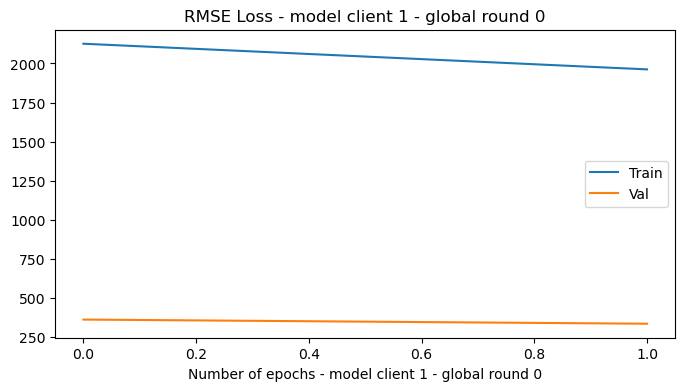

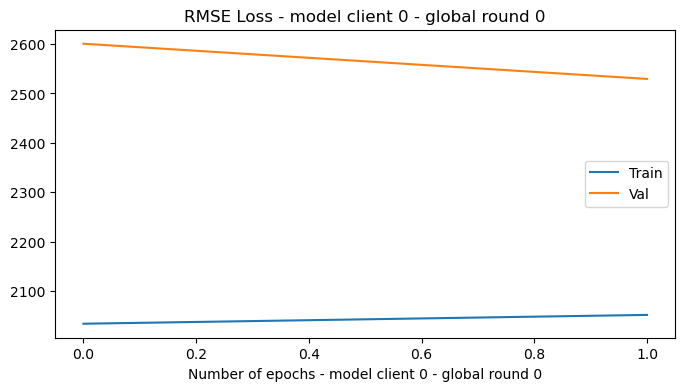

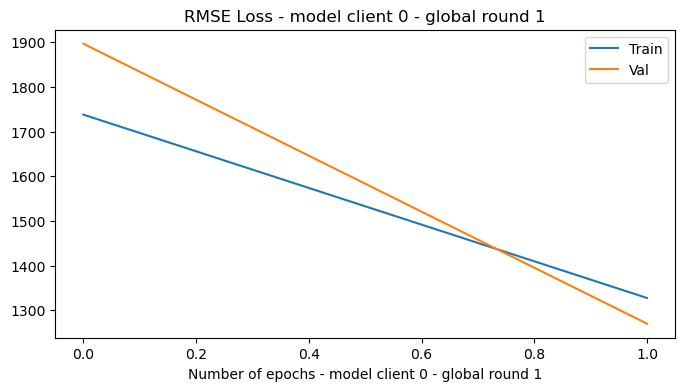

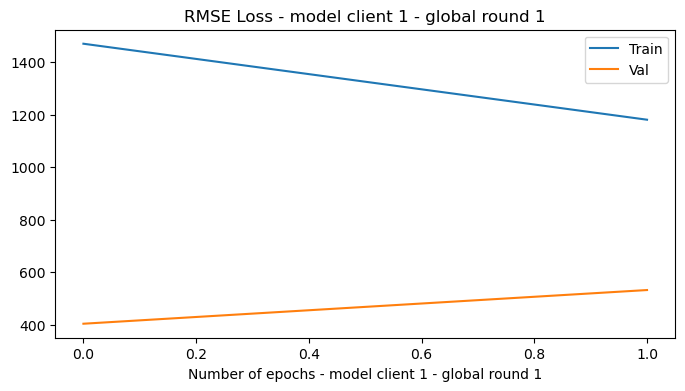

In [18]:
# create and add clients
clients_network = [create_client(i) for i in range(NUM_CLIENTS)]

# swarm simulation - fully connected graph
nodes, edges = simulate_fully_connected_graph(clients_network)

/home/s0001721/anaconda3/envs/zen/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10687 (\N{CIRCLED BULLET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


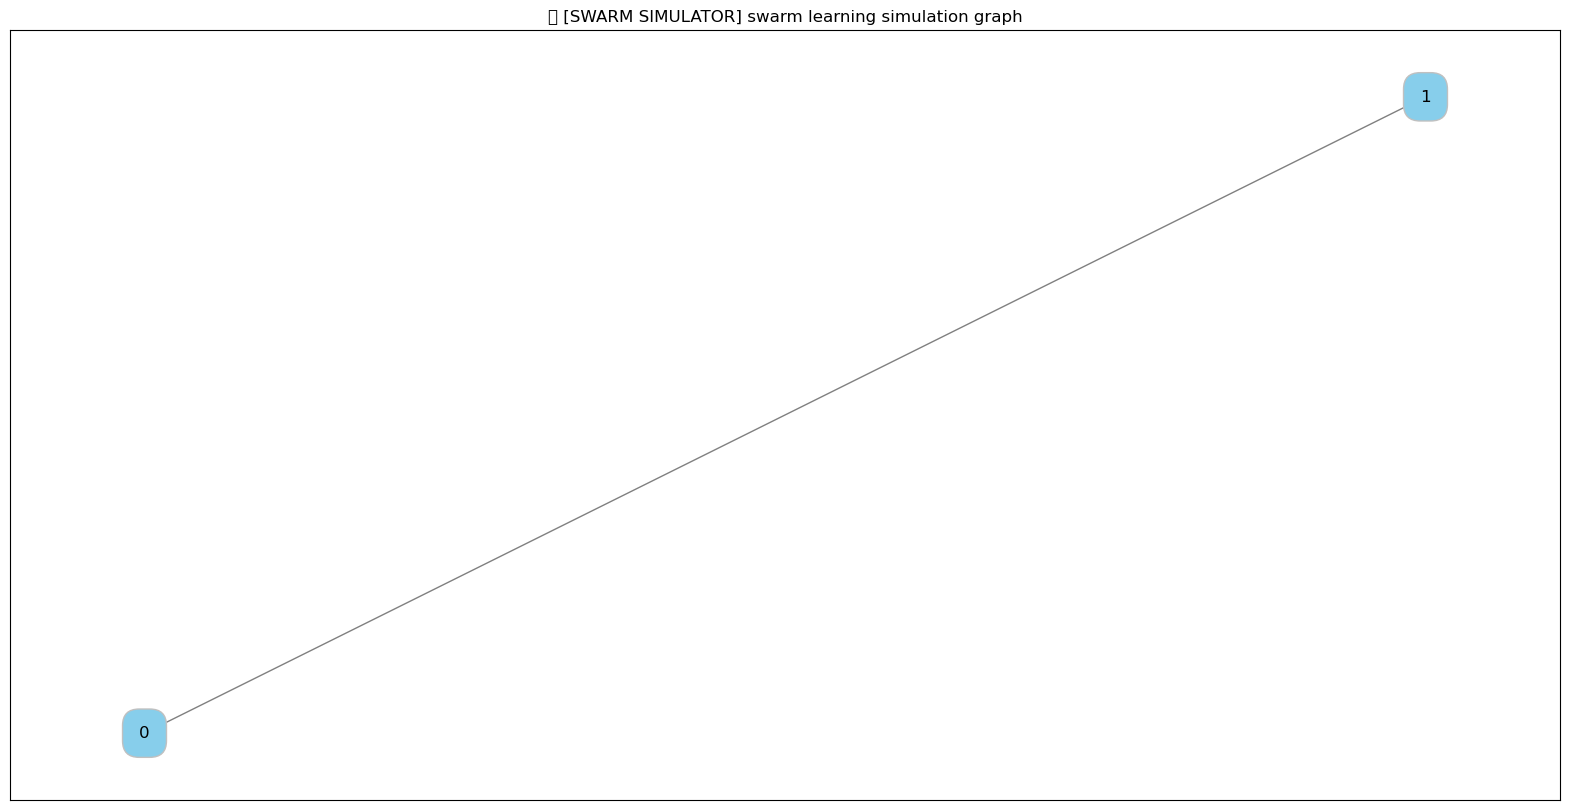

In [19]:
plot_typology_graph(nodes, edges)

🌻 Created new model - client 0 🌻
🌻 Created new model - client 1 🌻
⦿⦿⦿⦿⦿  [SWARM SIMULATOR] started global round 0 between the clients 
          {0, 1} ⦿⦿⦿⦿⦿ 
🚧🚧🚧[Client 0] global round 0 has started.🚧🚧🚧
[Client 0] updated status to Status.STARTED_GLOBAL_ROUND
🔭 [Client 0] discovering neighbours...
🔭 [Client 0] establised connection with the neighbours: set()
○ [Client 0] started local training - global round 0
⇉ Started transfer learning of model client 0 - global round 0
🚧🚧🚧[Client 1] global round 0 has started.🚧🚧🚧
[Client 1] updated status to Status.STARTED_GLOBAL_ROUND
🔭 [Client 1] discovering neighbours...
🔭 [Client 1] establised connection with the neighbours: set()
○ [Client 1] started local training - global round 0
⇉ Started transfer learning of model client 1 - global round 0
 ↪ Client0 Epoch 1: train loss 2136.474560546875,	 val loss 2585.0625
 ↪ Client1 Epoch 1: train loss 1878.3344848632812,	 val loss 363.5124206542969
 ↪ Client0 Epoch 2: train loss 2006.0364990234375,	 va

KeyboardInterrupt: 

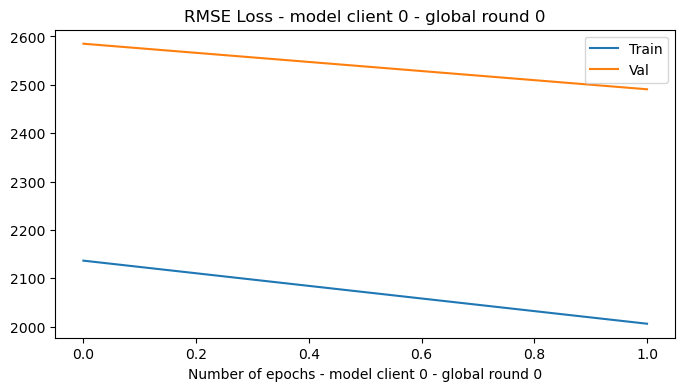

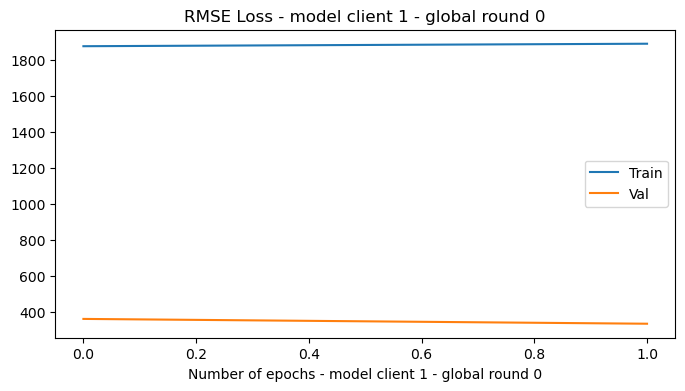

In [20]:
# create and add clients
clients_network = [create_client(i) for i in range(NUM_CLIENTS)]

# swarm simulation - dynamic graph
nodes, edges = simulate_random_dynamic_graph(clients_network)

In [ ]:
plot_typology_graph(nodes, edges)